## ANLY 590 Homework No.3
## Xi Yang

##  
## Problem No.1

In [1]:
# Load Required Packages for Problem 1
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Flatten

In [2]:
# Define the function to set up the model for problem 1
def p1_set_model():
    # Define input size
    input_size = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
    
    # Add convolutional layers for encoding
    layer = Conv2D(32, (3, 3), activation='relu', padding='same')(input_size)
    layer = MaxPooling2D((2, 2), padding='same')(layer)
    layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
    layer = MaxPooling2D((2, 2), padding='same')(layer)
    layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
    encoded = MaxPooling2D((2, 2), padding='same')(layer)

    # Add convolutional layers for decoding
    layer = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    layer = UpSampling2D((2, 2))(layer)
    layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
    layer = UpSampling2D((2, 2))(layer)
    layer = Conv2D(32, (3, 3), activation='relu')(layer)
    layer = UpSampling2D((2, 2))(layer)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)
    
    # Assemble model and output
    autoenc_model = Model(input_size, decoded)
    return autoenc_model

In [3]:
# Define function for prediction while encoding
def encode_pred(model,x_test,n):
    # Predict on test set
    decoded_imgs = model.predict(x_test)
    
    # Set figure size
    plt.figure(figsize=(n*2, 4))
    
    # Use for loop to print out some sample images
    for i in range(n):
        # Plot original picture
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Plot decoded picture
        ax = plt.subplot(2, n, i + n+1)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

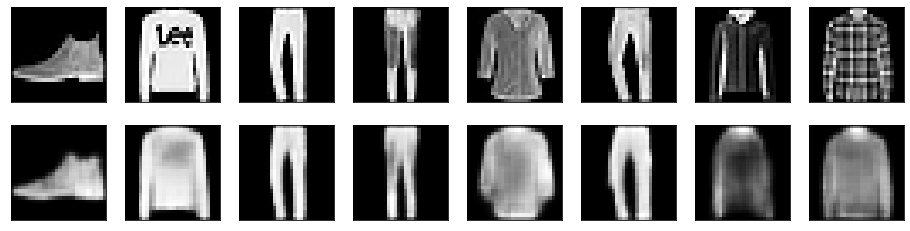

In [5]:
# Load Data
(x_train_1, _), (x_test_1, _) = fashion_mnist.load_data()

# Normalize the greyscale to be between 0 and 1
x_train_1 = x_train_1.astype('float32') / 255.
x_test_1 = x_test_1.astype('float32') / 255.

# Reshape the train and test data
x_train_1 = np.reshape(x_train_1,(len(x_train_1), 28, 28, 1))
x_test_1 = np.reshape(x_test_1, (len(x_test_1), 28, 28, 1))

# Set up the model
enc_model = p1_set_model()
enc_model.compile(optimizer='adam', loss='binary_crossentropy')
enc_model.summary()

# Train the model
enc_model.fit(x_train_1, x_train_1,
              epochs=8,
              batch_size=128,
              shuffle=True,
              validation_data=(x_test_1, x_test_1))

# Display some resutls
encode_pred(enc_model,x_test_1,8)

##   
## Problem No.2
###   
### 2.1 Deep CNN

In [6]:
# Import required packages for problem No.2
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Flatten

from tensorflow.keras.utils import to_categorical

from sklearn.metrics import mutual_info_score,roc_auc_score,confusion_matrix,accuracy_score, roc_curve, auc, classification_report

import cv2
from tensorflow.keras.applications.vgg16 import VGG16

### The following two functions shown in the code chunk below print classification report as well as confusion matrix:

In [7]:
# This function is used to print validation/test resuls
def print_validate(Y_val, predictions,
                   colors = "Blues", v_range = [0,1000]):
    conf_mat = confusion_matrix(Y_val, predictions)
    print("\nAccuracy score: ",accuracy_score(Y_val, predictions))
    print("\nConfusion Matrix: \n",conf_mat)
    print(classification_report(Y_val, predictions))

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(predictions, Y_val,
                          title='Confusion Matrix',
                          col_map = colors, v_range = v_range)

def plot_confusion_matrix(y_pred, y_true, title, col_map = "Blues", 
                          v_range = [0,1000]):
    conf_mat = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(conf_mat)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (8,7))
    plt.title(title, fontsize = 16)
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap=col_map, annot=True,annot_kws={"size": 16}, fmt='g',
                vmin=v_range[0], vmax=v_range[1])# font size

### The following function set up the convolutional model for problem 2.1:
### The CNN model has four layer in total: the first layer is a 2-D convolutional layer with 32 filters, each filter with (3,3) kernel size,  padding of "same", relu activation function, and stride of (1,1); the second layer is a 2-D maxpooling layer with size of (2,2) and padding of 'same'; the third layer has 16 filters and all other parameters same as the first convolutional layer; the fourth layer is another 2-D maxpooling layer with size of (2,2). The output layer is a dense layer using softmax activation function that outputs 10 classes.

In [8]:
def p2_build_model():
    input_size = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

    layer = Conv2D(32, (3, 3), activation='relu', padding='same')(input_size)
    layer = MaxPooling2D((2, 2), padding='same')(layer)
    layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
    layer = MaxPooling2D((2, 2), padding='same')(layer)
    layer = Flatten()(layer)
    output = Dense(10,activation="softmax")(layer)
    
    return Model(input_size,output)



### In the code chunks below, the model is trained and the results are shown:

In [9]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize grey scale
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape the data
x_train = np.reshape(x_train,(len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [10]:
# Binarize the y_lables using to_categorical function
y_train_bin = to_categorical(y_train)
y_test_bin = to_categorical(y_test)

# Build up the CNN model
p2_model = p2_build_model()
p2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
p2_model.summary()

# Train the deep CNN model
p2_fitted = p2_model.fit(x_train, y_train_bin,
                         epochs=30,
                         batch_size=128,
                         shuffle=True,
                         validation_data=(x_test, y_test_bin))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850

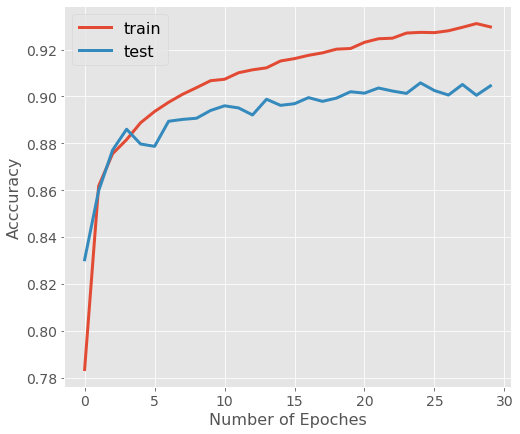

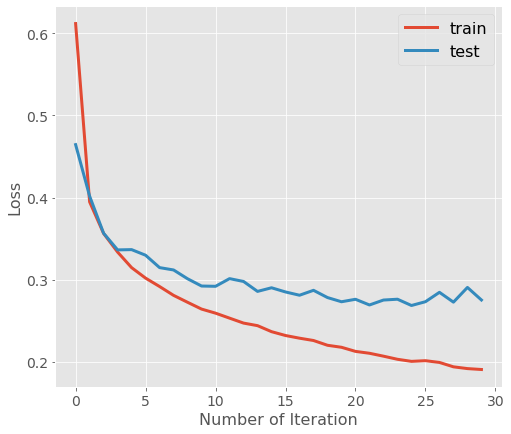

In [11]:
# Plot the model history
# Set up basic plotting parameters
plt.style.use('ggplot')
params = {'legend.fontsize': 16,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rcParams['axes.titlepad'] = 20 
matplotlib.rc('xtick',labelsize=14)
matplotlib.rc('ytick',labelsize=14)

# Plot train and test accuracies versus number of epoches
plt.figure(figsize=(8,7))
plt.plot(p2_fitted.history['accuracy'], label='train', linewidth = 3)
plt.plot(p2_fitted.history['val_accuracy'], label='test', linewidth = 3)
plt.xlabel('Number of Epoches', size = 16)
plt.ylabel('Acccuracy', size = 16)
plt.legend(prop={'size': 6})
plt.legend()

#plt.tight_layout()
plt.show()

# Plot train and test losses versus number of epoches
plt.figure(figsize=(8,7))
plt.plot(p2_fitted.history['loss'], label='train', linewidth = 3)
plt.plot(p2_fitted.history['val_loss'], label='test', linewidth = 3)
plt.xlabel('Number of Iteration', size = 16)
plt.ylabel('Loss', size = 16)
plt.legend(prop={'size': 6})
#plt.ylim([0,1])
plt.legend()

#plt.tight_layout()
plt.show()

### Train Results:

Train Results:

Accuracy score:  0.9342

Confusion Matrix: 
 [[5456    3   74   46    9    3  392    0   17    0]
 [   2 5962    1   22    6    1    6    0    0    0]
 [  71    2 5425   17  254    0  226    0    5    0]
 [ 128   19   85 5374  224    0  162    0    8    0]
 [   7    6  259   55 5348    0  318    0    7    0]
 [   0    0    0    0    0 5971    0   20    1    8]
 [ 605    3  286   58  224    0 4804    0   20    0]
 [   0    0    0    0    0   39    0 5909    0   52]
 [   5    0    3    2    4    3    5    1 5977    0]
 [   0    0    0    0    0   12    0  162    0 5826]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      6000
           1       0.99      0.99      0.99      6000
           2       0.88      0.90      0.89      6000
           3       0.96      0.90      0.93      6000
           4       0.88      0.89      0.89      6000
           5       0.99      1.00      0.99      6000
           6       0.81      

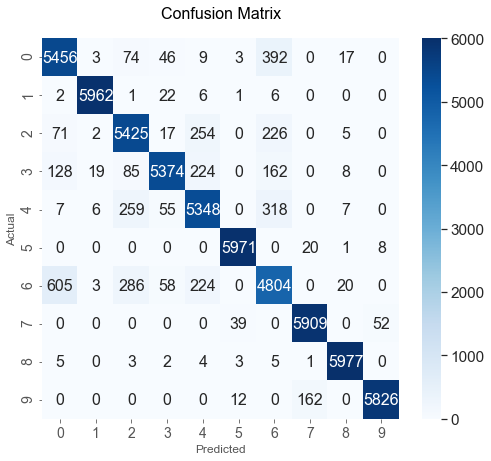

In [12]:
# Generate prediction on train dataset
prob_train = p2_model.predict(x_train) 
pred_train = prob_train.argmax(axis=-1)

# Print out Train results
print('Train Results:')
print_validate(y_train, pred_train, colors = "Blues", v_range = [0,6000])

### Test Results:

Test Results:

Accuracy score:  0.9045

Confusion Matrix: 
 [[868   0  23   9   5   3  83   0   9   0]
 [  1 984   1   7   3   0   3   0   1   0]
 [ 18   2 867   6  51   0  54   0   2   0]
 [ 27   6  20 861  44   1  39   0   2   0]
 [  1   1  57  12 859   0  70   0   0   0]
 [  0   0   0   0   0 983   0  11   0   6]
 [127   1  71  21  62   0 710   0   8   0]
 [  0   0   0   0   0  12   0 976   1  11]
 [  3   2   1   2   1   3   2   3 983   0]
 [  0   0   0   0   0   5   1  40   0 954]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.83      0.87      0.85      1000
           3       0.94      0.86      0.90      1000
           4       0.84      0.86      0.85      1000
           5       0.98      0.98      0.98      1000
           6       0.74      0.71      0.72      1000
           7       0.95      0.98      0.96      1000
           8       0.9

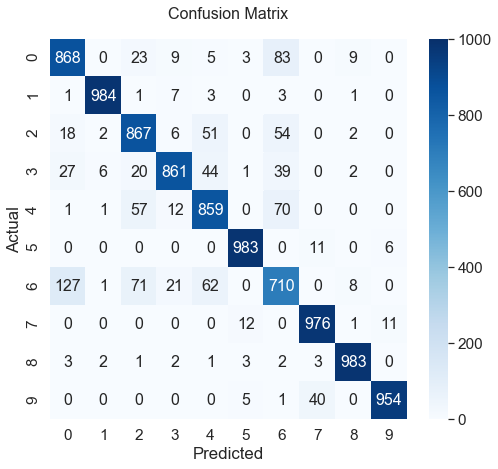

In [13]:
# Generate prediction on test dataset
prob_test = p2_model.predict(x_test) 
pred_test = prob_test.argmax(axis=-1)

# Print out Test results
print('Test Results:')
print_validate(y_test, pred_test, colors = "Blues", v_range = [0,1000])

###   
### 2.2 Transfer Learning

In [14]:
# Problem 2.2

# Load the dataset for the problem
(x_train_22, y_train_22), (x_test_22, y_test_22) = fashion_mnist.load_data()

# Change the picture from greyscale to RGB for pretrained model
x_train_22 = [cv2.cvtColor(cv2.resize(i, (32,32)), cv2.COLOR_GRAY2BGR) for i in x_train_22]
x_test_22 = [cv2.cvtColor(cv2.resize(i, (32,32)), cv2.COLOR_GRAY2BGR) for i in x_test_22]

# Set up the dataset 
x_train_22 = np.concatenate([arr[np.newaxis] for arr in x_train_22]).astype('float32')
x_test_22 = np.concatenate([arr[np.newaxis] for arr in x_test_22]).astype('float32')

In [15]:
# Build the model
# Using VGG16 as the pretrianed model
model_22 = VGG16(weights='imagenet', include_top=False)

# Let VGG16 model layers to be fixed
for layer in model_22.layers:
    layer.trainable = False

# Set up input and output
input_22 = Input(shape=(32,32,3))
output_vg16_22 = model_22(input_22)

# Add Dense layers after the pretrained model
layer_22 = Flatten()(output_vg16_22)
layer_22 = Dense(300, activation='relu')(layer_22)
layer_22 = Dense(100, activation='relu')(layer_22)
layer_22 = Dense(10, activation='softmax')(layer_22)

# Assembly the model
pretrained_22 = Model(inputs=input_22, outputs=layer_22)

# Compile the model
pretrained_22.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
p22_fitted = pretrained_22.fit(x_train_22, y_train_22, validation_data=(x_test_22, y_test_22), epochs=3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 237s 4ms/sample - loss: 0.6336 - accuracy: 0.7981 - val_loss: 0.4933 - val_accuracy: 0.8230
Epoch 2/3
60000/60000 [==============================] - 243s 4ms/sample - loss: 0.4212 - accuracy: 0.8460 - val_loss: 0.4589 - val_accuracy: 0.8378
Epoch 3/3
60000/60000 [==============================] - 236s 4ms/sample - loss: 0.3831 - accuracy: 0.8591 - val_loss: 0.4505 - val_accuracy: 0.8368


### Train Results:

Train Results:

Accuracy score:  0.8694833333333334

Confusion Matrix: 
 [[5037    0  126  127   34    1  626    0   49    0]
 [   2 5869   14  100    6    0    8    0    1    0]
 [  82    6 4359   29  905    0  601    0   18    0]
 [ 289   40   28 4902  294    2  414    0   31    0]
 [  19    4  206  150 4932    0  668    0   21    0]
 [   0    0    0    0    0 5763    0  143   23   71]
 [ 587    2  247  131  678    3 4321    0   31    0]
 [   0    0    0    0    0  248    0 5564   25  163]
 [  24    0   47    9   18   16   42    0 5839    5]
 [   8    0    0    0    0   51    4  271   83 5583]]
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      6000
           1       0.99      0.98      0.98      6000
           2       0.87      0.73      0.79      6000
           3       0.90      0.82      0.86      6000
           4       0.72      0.82      0.77      6000
           5       0.95      0.96      0.95      6000
           6     

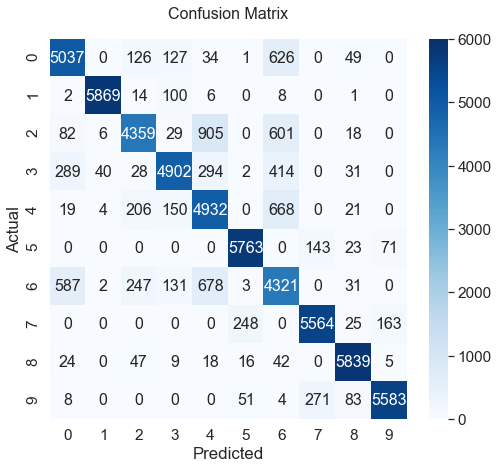

In [17]:
# Generate prediction on train dataset
prob_train_22 = pretrained_22.predict(x_train_22) 
pred_train_22 = prob_train_22.argmax(axis=-1)

# Print out Train results
print('Train Results:')
print_validate(y_train_22, pred_train_22, colors = "Blues", v_range = [0,6000])

### Test Results:

Test Results:

Accuracy score:  0.8368

Confusion Matrix: 
 [[795   2  20  30  12   1 121   0  19   0]
 [  2 964   4  19   5   0   3   0   3   0]
 [ 13   0 695   3 157   0 129   0   3   0]
 [ 54  12   7 749  72   0  99   0   7   0]
 [  2   0  46  25 790   0 134   0   3   0]
 [  0   0   0   0   0 929   0  49   4  18]
 [119   0  49  33 132   1 656   0  10   0]
 [  0   0   0   0   0  34   0 929   6  31]
 [  8   0  13   3   7   7  14   1 946   1]
 [  2   0   0   0   0  10   2  54  17 915]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1000
           1       0.99      0.96      0.97      1000
           2       0.83      0.69      0.76      1000
           3       0.87      0.75      0.80      1000
           4       0.67      0.79      0.73      1000
           5       0.95      0.93      0.94      1000
           6       0.57      0.66      0.61      1000
           7       0.90      0.93      0.91      1000
           8       0.9

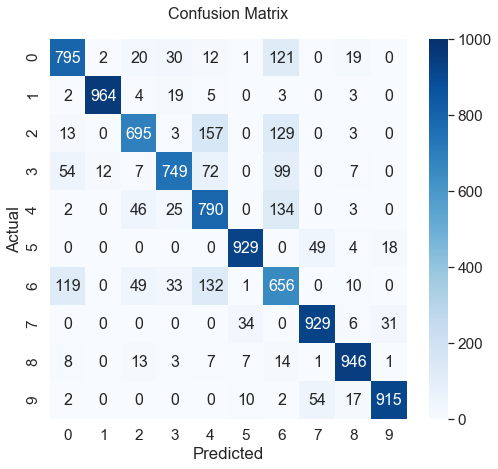

In [18]:
# Generate prediction on Test dataset
prob_test_22 = pretrained_22.predict(x_test_22) 
pred_test_22 = prob_test_22.argmax(axis=-1)

# Print out Test results
print('Test Results:')
print_validate(y_test_22, pred_test_22, colors = "Blues", v_range = [0,1000])

##   
## Problem No.3
###   
### 3.1 RNN

In [20]:
# Import packages for this problem
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Embedding
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Conv1D,GlobalMaxPooling1D

import matplotlib.pyplot as plt

from sklearn.metrics import mutual_info_score,roc_auc_score,confusion_matrix,accuracy_score, roc_curve, auc, classification_report


### Define a function to process the twitter text

In [21]:
# This function perform basic clean on the text
def process_text(document):  
    # Remove all the special characters
    document = re.sub(r'\W', ' ', document)
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Converting to Lowercase
    document = document.lower()
    
    return document

### Define a function to set up the RNN model

In [22]:
# This function defines the RNN model with LSTM
def set_model_p31(max_length, max_feature):
    # Set input for the model
    input_p31 = Input(shape=(max_length))
    
    # Add layers
    layer = Embedding(max_feature, 32)(input_p31)
    layer = LSTM(32)(layer)
    
    # Add output layer
    output_p31 = Dense(15, activation='sigmoid')(layer)
    
    # Return the model
    return Model(input_p31,output_p31)

### Load and process the dataset

In [23]:
# Read in the dataset to a dataframe
df_tweets = pd.read_csv('tweets_with_labels.csv',sep='\t',error_bad_lines=False)
df_tweets.dropna(axis = 0, inplace = True)

# Generate X and y dataset
X_3 = [process_text(t) for t in list(df_tweets['tweet'])]
y_3 = df_tweets.drop(['id', 'tweet'], axis = 1).values

# Split train and test data
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.3, random_state=117)

# Tokenize the text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_3)

# Convert the text to sequences
X_train_3 = tokenizer.texts_to_sequences(X_train_3)
X_test_3 = tokenizer.texts_to_sequences(X_test_3)

# Define max feature and max length
max_feature = 8000
max_length = 64

# Prepare the dataset finally
X_train_3 = pad_sequences(X_train_3, padding = 'post', maxlen = max_length)
X_test_3 = pad_sequences(X_test_3, padding = 'post', maxlen = max_length)

### Train the model

In [24]:
# Call the function to set up the model and compile
p31_model = set_model_p31(max_length, max_feature)
p31_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
p31_model.summary()

# Train the model
p31_fitted = p31_model.fit(X_train_3, y_train_3,
                         epochs=20,
                         batch_size=64,
                         shuffle=True,
                         validation_data=(X_test_3, y_test_3))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 64, 32)            256000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                495       
Total params: 264,815
Trainable params: 264,815
Non-trainable params: 0
_________________________________________________________________
Train on 54562 samples, validate on 23384 samples
Epoch 1/20
54562/54562 [==============================] - 30s 542us/sample - loss: 2.7061 - accuracy: 0.2798 - val_loss: 2.6840 - val_accuracy: 0.2856
Epoch 2/20
54562/54562 [==========================

### Check results

In [25]:
# Evaluate the model
loss_train_31, acc_train_31 = p31_model.evaluate(X_train_3, y_train_3, verbose = 0) 
loss_test_31, acc_test_31 = p31_model.evaluate(X_test_3, y_test_3, verbose = 0) 

# Print evaluation results
print('Train:\nLoss = ', loss_train_31, '\tAccuracy = ',acc_train_31 )
print('\n\nTest:\nLoss = ', loss_test_31, '\tAccuracy = ',acc_test_31 )

Train:
Loss =  1.0548687580896303 	Accuracy =  0.8460284


Test:
Loss =  1.1864617025652366 	Accuracy =  0.81551486


###   
### 3.2 CNN

### Define a function to set up the model for problem 3.2

In [26]:
def set_model_p32(max_length, max_feature):
    # Set up input size
    input_p32 = Input(shape=(max_length))
    
    # Add layers
    layer = Embedding(max_feature, 32)(input_p32)
    layer = Conv1D(64,3,padding='same',activation='relu',strides=1)(layer)
    layer = GlobalMaxPooling1D()(layer)
    layer = Dense(150,activation="relu")(layer)
    
    # Set up output and return the model
    output_p32 = Dense(15, activation='sigmoid')(layer)
    return Model(input_p32,output_p32)

### Train the model

In [27]:
# Call the function to set up the model and compile
p32_model = set_model_p32(max_length, max_feature)
p32_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
p32_model.summary()

# Train the model
p32_fitted = p32_model.fit(X_train_3, y_train_3,
                          epochs=5,
                          batch_size=64,
                          shuffle=True,
                          validation_data=(X_test_3, y_test_3))

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 32)            256000    
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 64)            6208      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 150)               9750      
_________________________________________________________________
dense_6 (Dense)              (None, 15)                2265      
Total params: 274,223
Trainable params: 274,223
Non-trainable params: 0
_____________________________________________________

### Check basic results

In [28]:
# Evaluate the model
loss_train_32, acc_train_32 = p32_model.evaluate(X_train_3, y_train_3, verbose = 0) 
loss_test_32, acc_test_32 = p32_model.evaluate(X_test_3, y_test_3, verbose = 0) 

# Print evaluation results
print('Train:\nLoss = ', loss_train_32, '\tAccuracy = ',acc_train_32 )
print('\n\nTest:\nLoss = ', loss_test_32, '\tAccuracy = ',acc_test_32 )

Train:
Loss =  0.9102583404667701 	Accuracy =  0.8674902


Test:
Loss =  1.091727680655077 	Accuracy =  0.83052516


###   
### 3.3 Results Comparision
###   
### Define a function to draw ROC curve

In [29]:
# This function is used to draw ROC curves
def draw_roc(y_true, y_31, y_32, class_no):
    # Compute FPR and TPR for both methods
    fpr_31, tpr_31, _ = roc_curve(y_true, y_31)
    fpr_32, tpr_32, _ = roc_curve(y_true, y_32)
    
    # Compute AUC for both curves
    roc_auc_31 = auc(fpr_31, tpr_31)
    roc_auc_32 = auc(fpr_32, tpr_32)
    
    # Plot ROC curves for RNN and CNN
    plt.subplot(3,5,class_no)
    plt.plot(fpr_31, tpr_31,  lw=2.5, color = 'royalblue', linestyle = '-', 
             alpha = 0.8, label='{0} (AUC = {1:0.2f})'
                                 ''.format('RNN', roc_auc_31))
    plt.plot(fpr_32, tpr_32,  lw=2.5, color = 'lightcoral', linestyle = '--', 
             alpha = 0.8, label='{0} (AUC = {1:0.2f})'
                                 ''.format('CNN', roc_auc_32))
    
    # Set plot parameters
    plt.plot([0, 1], [0, 1], 'k--', lw = 4)
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Class No.'+str(class_no))
    plt.legend(loc="lower right", fontsize = 12, handlelength=4)

### Make Prediction

In [30]:
# Using the RNN model from 3.1 and CNN model from 3.2 to make prediction on test set
prob_31 = p31_model.predict(X_test_3)
prob_32 = p32_model.predict(X_test_3)

### Plot ROC Curves

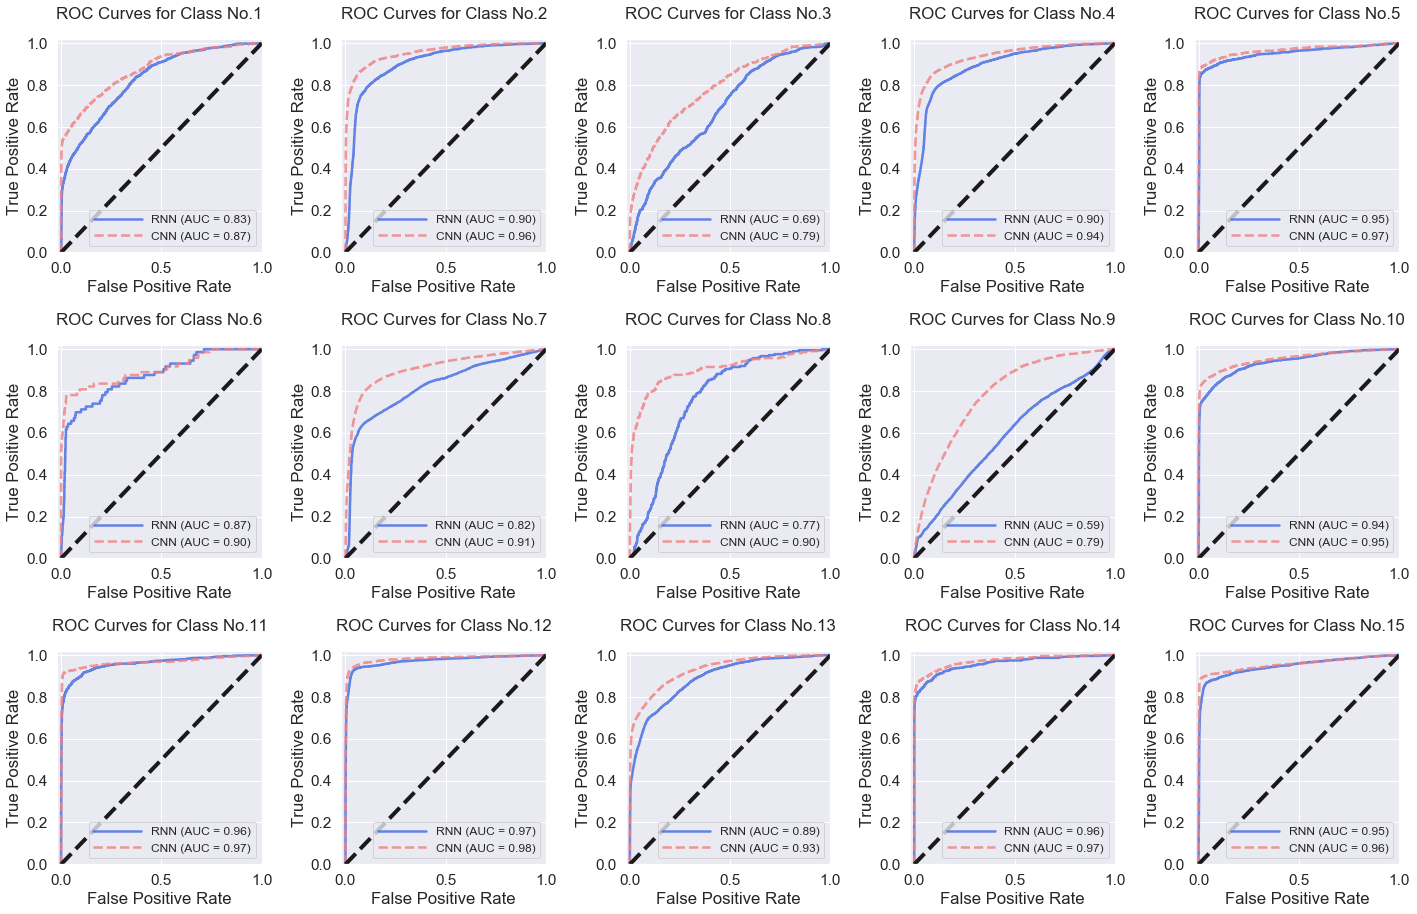

In [36]:
# Set figure size
plt.figure(figsize = (20, 13))

# Iterate through all classes
for i in range(15):
    # Get probability from RNN and CNN model
    prob_31_temp = prob_31[:,i]
    prob_32_temp = prob_32[:,i]
    
    # Set up true label
    true_target = y_test_3[:,i]>0
    
    # Call function to draw roc curves
    draw_roc(true_target, prob_31_temp, prob_32_temp, i+1)

# Set tight layout and show the plot
plt.tight_layout()
plt.show()


### Both models performs well for most classes' prediction like for class No. 11 and 12. However, CNN performs better than RNN with LSTM in most cases especially for class No. 3, 7, 8, and 9. Also, CNN model converges much faster than RNN with LSTM.